## **Latihan Imbalanced Classification**

### **Gunakan dataset stroke**

1. Eksplor datasetnya terlebih dahulu.
    - drop outlier gender = 'Other'
2. Lakukan tahap pre-processing yang menurut kamu dibutuhkan untuk dataset ini.
3. Target: 'stroke', features: gunakan feature yang menurut kamu berguna dalam pemodelan ini.
4. Untuk pemodelan, gunakan model benchmark: Decision Tree
5. Coba lakukan 3 skenario handling imbalance dataset
    - Penalized (class_weight)
    - Undersampling: RandomUnderSampler()
    - Oversampling: SMOTE()
6. Terlepas dari hasil terbaik dari 3 skenario di atas, coba lakukan hyperparameter tuning model dengan SMOTE (boleh dengan RandomizedSearch)
7. Bandingkan hasil sebelum dan sesudah tuning

## **Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, classification_report, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, average_precision_score, plot_precision_recall_curve

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline # SMOTE

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')

* https://imbalanced-learn.org/stable/references/generated/imblearn.pipeline.Pipeline.html


In [ ]:
df = pd.read_csv('stroke.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## **Feature Information**

- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"
- stroke: 1 if the patient had a stroke or 0 if not *Note: "Unknown" in smoking_status means that the information is unavailable for this patient

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
df.describe(include='all').replace(np.NaN,'')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110,5110,5110,5110,5110,5110,5110,5110,5110,4909,5110,5110
unique,,3,,,,2,5,2,,,4,
top,,Female,,,,Yes,Private,Urban,,,never smoked,
freq,,2994,,,,3353,2925,2596,,,1892,
mean,36517.8,,43.2266,0.097456,0.0540117,,,,106.148,28.8932,,0.048728
std,21161.7,,22.6126,0.296607,0.226063,,,,45.2836,7.85407,,0.21532
min,67,,0.08,0,0,,,,55.12,10.3,,0
25%,17741.2,,25,0,0,,,,77.245,23.5,,0
50%,36932,,45,0,0,,,,91.885,28.1,,0
75%,54682,,61,0,0,,,,114.09,33.1,,0


## **EDA**

In [ ]:
cat_features = [feature for feature in df.columns if (df[feature].dtypes == 'O')]
cat_features

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
for i in cat_features:
    print(f'Total unique values in {i}: ', df[i].nunique())
    print(f'Unique values: ', df[i].unique())
    print()

Total unique values in gender:  3
Unique values:  ['Male' 'Female' 'Other']

Total unique values in ever_married:  2
Unique values:  ['Yes' 'No']

Total unique values in work_type:  5
Unique values:  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Total unique values in Residence_type:  2
Unique values:  ['Urban' 'Rural']

Total unique values in smoking_status:  4
Unique values:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']



In [ ]:
for i in cat_features:
    print(df[i].value_counts())
    print()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

Yes    3353
No     1757
Name: ever_married, dtype: int64

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [ ]:
df[df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [ ]:
# Drop 'other' in gender
df.drop(index=3116, inplace=True)

In [ ]:
df[df['gender'] == 'Other']


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
num_features = list(df.describe().columns)
num_features

['id',
 'age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'stroke']

In [ ]:
filtering = df.filter(['gender','heart_disease','hypertension'])
suffer_gender = filtering.groupby('gender').count().reset_index()
suffer_gender

,gender,heart_disease,hypertension
0,Female,2994,2994
1,Male,2115,2115


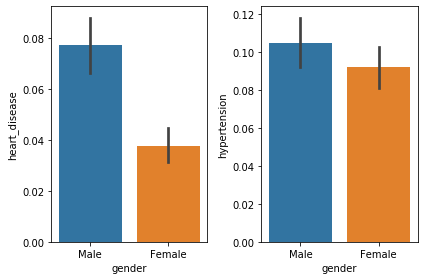

In [ ]:
fid, ax = plt.subplots(1, 2)

ax1 = sns.barplot(data=df, x='gender', y='heart_disease', ax=ax[0])
ax2 = sns.barplot(data=df, x='gender', y='hypertension', ax=ax[1])

plt.tight_layout()

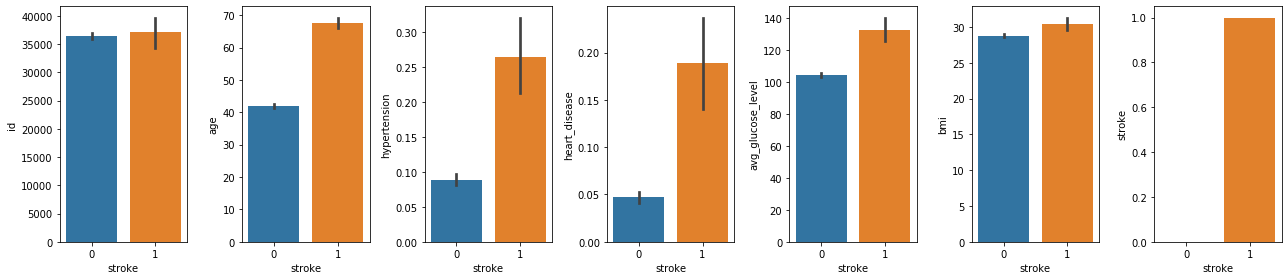

In [ ]:
fig, ax = plt.subplots(1, len(num_features), figsize=(18,4))

for i in range(len(num_features)):
    sns.barplot(data=df, x='stroke', y=num_features[i], ax=ax[i])
    plt.tight_layout()


In [ ]:
# imbalance dataset
df['stroke'].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [ ]:
# imbalance dataset (in percent)
df['stroke'].value_counts()/len(df['stroke'])*100

0    95.126248
1     4.873752
Name: stroke, dtype: float64

## **Drop unused column**
column 'id' hanya berupa urutan nomor, tidak akan menentukan stroke

In [ ]:
# Drop unused column
df.drop(columns=['id'], inplace=True)
df

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


## **Define X and y**

In [ ]:
X = df.drop(columns=['stroke'], axis=1)
y = df['stroke']

In [ ]:
y.value_counts()

0    4860
1     249
Name: stroke, dtype: int64

## **Data Splitting**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    stratify = y,
    test_size = 0.2,
    random_state = 42
)

## **Pre-processing and Data Transform**

In [ ]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
# Transformer
transformer = ColumnTransformer([
    ('imputer', IterativeImputer(max_iter=10, random_state=42), ['bmi']),
    ('one hot', OneHotEncoder(drop='first'), ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'])
],  remainder='passthrough')

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('imputer', IterativeImputer(random_state=42),
                                 ['bmi']),
                                ('one hot', OneHotEncoder(drop='first'),
                                 ['gender', 'ever_married', 'work_type',
                                  'Residence_type', 'smoking_status'])])

In [ ]:
# Scaler
scaler = StandardScaler()

## **Model Benchmark (without Balancing)**
Melihat hasil cross validation dari model benchmark dengan Decision Tree, tanpa imbalance treatment

In [ ]:
# Define models
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# Model Decision Tree dengan pipeline
model = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('model', tree)
    ])

skf = StratifiedKFold(n_splits=5)

# fitting
model_cv = cross_val_score(
    model,
    X_train,
    y_train,
    scoring='f1',
    cv=skf
    )

print(model_cv)
print(model_cv.mean())


[0.         0.04166667 0.04444444 0.         0.04166667]
0.025555555555555554


## **Penalized**

Kita coba gunakan class_weight untuk mengatasi imbalance data

In [ ]:
# Define models
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42, class_weight='balanced')

# Model Decision Tree dengan pipeline
model = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('model', tree)
    ])

skf = StratifiedKFold(n_splits=5)

# fitting
model_cv = cross_val_score(
    model,
    X_train,
    y_train,
    scoring='f1',
    cv=skf
    )

print(model_cv)
print(model_cv.mean())


[0.19852941 0.23859649 0.20408163 0.2170088  0.21789883]
0.21522303319692426


## **Under-sampling**

Kita coba lakukan undersampling untuk mengatasi imbalance data.
Resiko:
- Data berkurang
- Kehilangan informasi
- Penurunan performa

In [ ]:
y_train.value_counts()

0    3888
1     199
Name: stroke, dtype: int64

In [ ]:
# handling imbalance data
rus = RandomUnderSampler(random_state=42)

# balancing
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [ ]:
y_train_under.value_counts()

1    199
0    199
Name: stroke, dtype: int64

\* Kita akan gunakan Pipeline saja untuk menghindari information leakage

In [ ]:
# handling imbalance data
rus = RandomUnderSampler(random_state=42)

# Define models
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# Model Decision Tree dengan pipeline
model = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('balancing', rus),
        ('model', tree)
    ])


skf = StratifiedKFold(n_splits=5)

# cross val
model_cv = cross_val_score(
    model,
    X_train,
    y_train,
    scoring='f1',
    cv=skf
    )

print(model_cv)
print(model_cv.mean())

[0.17330211 0.18941504 0.17534247 0.17754569 0.15053763]
0.1732285883158198


## **Over-sampling**

Kita coba lakukan oversampling untuk mengatasi imbalance data.

Resiko:
- overfitting pada data yang diduplikasi
- jika data yang diduplikat terlalu banyak, kemungkinan memperburuk performa model

In [ ]:
# handling imbalance data
smote = SMOTE(random_state=42)

# Define models
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# Model Decision Tree dengan pipeline
model = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('imbalance', smote),
        ('model', tree)
    ])

skf = StratifiedKFold(n_splits=5)

# cross val
model_cv = cross_val_score(
    model,
    X_train,
    y_train,
    scoring='f1',
    cv=skf
    )

print(model_cv)
print(model_cv.mean())



[0.20512821 0.21587302 0.15282392 0.2        0.20535714]
0.1958364568248289


## Kesimpulan dari cross validation

f1-score:
- no treatment = 0.025
- penalized = 0.215
- under sampling = 0.173
- over sampling = 0.195

Dari 3 metode handling imbalace dataset tersebut, f1-score paling besar diperoleh dengan menggunakan metode Penalized

## **Hyperparameter Tuning**
Coba melakukan hyperparameter tuning pada model decision tree dengan treatment SMOTE

In [ ]:
# model.get_params()

In [ ]:
# balancing method
smote = SMOTE(random_state=42)

# model benchmark
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=1, random_state=42)

# algorithm chains
model = Pipeline([
    ('transform', transformer),
    ('scale', scaler),
    ('balancing', smote),
    ('model', tree)
])

# Hyperparameter space
hyperparam_space = {
    'balancing__k_neighbors':[2,5,10,15,20],            # benchmark: 5, kombinasi = 5
    'model__criterion':['gini','entropy'],              # benchmark: entropy, kombinasi = 2
    'model__min_samples_leaf':[1, 5, 10, 15, 20, 50],   # benchmark: 1, kombinasi = 6
    'model__max_depth':[2, 3, 4, 5, 6, 7],              # benchmark: 5, kombinasi = 6
    'scale':[StandardScaler(), RobustScaler()]
}

# # Hyperparameter space
# hyperparam_space = {
#     'balancing__k_neighbors':np.arange(1,20,1),     # benchmark: 5
#     'model__criterion':['gini','entropy'],          # benchmark: entropy
#     'model__min_samples_leaf':np.arange(1,100,1),   # benchmark: 1
#     'model__max_depth':np.arange(1,20,1),           # benchmark: 5
#     'scale':[StandardScaler(), RobustScaler()]
# }


# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Hyperparameter tuning
random_search = RandomizedSearchCV(
    model, # model to tune
    param_distributions = hyperparam_space, # hyperparameter space
    cv = skf, # evaluation method
    scoring = 'f1', # metrics
    n_iter = 30, # sampling
    n_jobs = -1, # use all cores
    verbose = 1 # / 2 / 3 / 4
)

In [ ]:
# tuning
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('transform',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('imputer',
                                                                               IterativeImputer(random_state=42),
                                                                               ['bmi']),
                                                                              ('one '
                                                                               'hot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['gender',
                                                                                'ever_married',
        

In [ ]:
print('best score',random_search.best_score_)
print('best param',random_search.best_params_)

best score 0.21532417342561438
best param {'scale': StandardScaler(), 'model__min_samples_leaf': 15, 'model__max_depth': 2, 'model__criterion': 'entropy', 'balancing__k_neighbors': 20}


In [ ]:
pd.DataFrame(random_search.cv_results_).sort_values(by='rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scale,param_model__min_samples_leaf,param_model__max_depth,param_model__criterion,param_balancing__k_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,0.170600,0.024664,0.050401,0.017153,StandardScaler(),15,2,entropy,20,"{'scale': StandardScaler(), 'model__min_sample...",0.223602,0.249084,0.195804,0.230216,0.177914,0.215324,0.025340,1
9,0.151402,0.030742,0.040796,0.002788,StandardScaler(),20,2,gini,2,"{'scale': StandardScaler(), 'model__min_sample...",0.223602,0.249084,0.195804,0.206349,0.193050,0.213578,0.020740,2
2,0.133202,0.018915,0.043798,0.010909,StandardScaler(),5,2,gini,10,"{'scale': StandardScaler(), 'model__min_sample...",0.223602,0.197333,0.195804,0.230216,0.177914,0.204974,0.019281,3
13,0.105201,0.008999,0.033001,0.002280,StandardScaler(),10,2,gini,10,"{'scale': StandardScaler(), 'model__min_sample...",0.223602,0.197333,0.195804,0.230216,0.177914,0.204974,0.019281,3
26,0.133803,0.010962,0.032399,0.002061,RobustScaler(),10,2,entropy,2,"{'scale': RobustScaler(), 'model__min_samples_...",0.178082,0.241379,0.195804,0.230216,0.177914,0.204679,0.026463,5


## **Model Performance in Test Set**
**Before & after tuning of Decision Tree model with SMOTE**

### **Before**

In [ ]:
# Handling imbalance
smote = SMOTE(random_state=42)

# Define model benchmark
tree = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42)

# Model Decision Tree dengan pipeline
model = Pipeline([
        ('transform', transformer),
        ('scale', scaler),
        ('imbalance', smote),
        ('model', tree)
    ])

# fitting
model.fit(X_train,y_train)

# predict
y_pred = model.predict(X_test)

# score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.64      0.78       972
           1       0.11      0.82      0.19        50

    accuracy                           0.65      1022
   macro avg       0.55      0.73      0.48      1022
weighted avg       0.94      0.65      0.75      1022



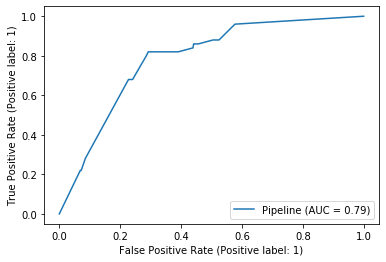

In [ ]:
plot_roc_curve(model, X_test, y_test)

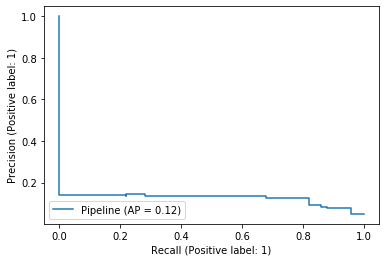

In [ ]:
plot_precision_recall_curve(model, X_test, y_test)

### **After**

In [ ]:
# fitting

model = random_search.best_estimator_
model.fit(X_train, y_train)

# predict
y_pred_tuning = model.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred_tuning))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.82      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.73      0.81      1022



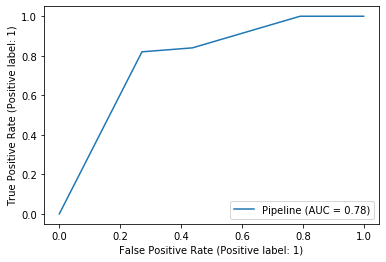

In [ ]:
plot_roc_curve(model, X_test, y_test)

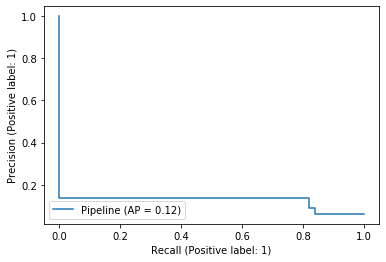

In [ ]:
plot_precision_recall_curve(model, X_test, y_test)

### **confusion matrix**

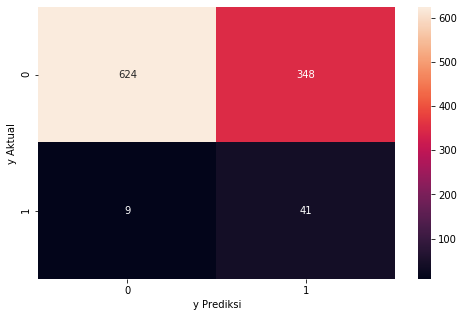

In [ ]:
# before tuning

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

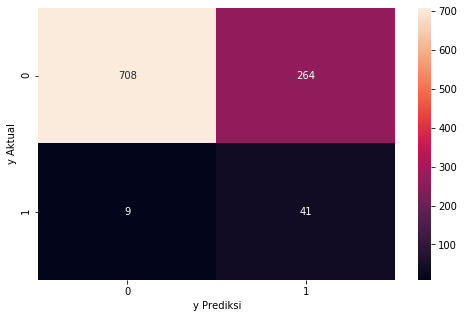

In [ ]:
# after tuning

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_tuning), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

## **Interpretasi**

TP: Model memprediksi orang mengidap penyakit stroke dan aktualnya memang iya (41).<br>
FP: Model memprediksi orang mengidap penyakit stroke, tetapi aktualnya tidak (264).
<br><br>
TN: Model memprediksi orang tidak mengidap penyakit stroke dan aktualnya memang tidak (708).<br>
FN: Model memprediksi orang tidak mengidap penyakit stroke, tetapi aktualnya mengidap penyakit stroke (9).
<br><br>

- Dalam kasus ini, FP dan FN sama-sama penting karena False Positive dapat mengakibatkan orang tersebut melakukan pengobatan yang sebenarnya tidak diperlukan dan False Negative dapat menyebabkan kesalahan dalam diagnosis, yang mana menjadi hal yang serius karena penyakit stroke tersebut tidak ditangani sesegera mungkin.

- Setelah dilakukan hyperparameter tuning, f1-score naik dari 0.19 menjadi 0.23.

- Karena jumlah sample kelas negatif jauh lebih banyak dari kelas positif, dari confusion matrix plot dapat dilihat bahwa banyak terdapat samples kelas negatif yang bisa menjadi false positive. Sebaliknya, karena sample kelas positif hanya berjumlah sedikit, maka sedikit pula samples kelas positif yang menjadi false negatif.

## THRESHOLD OPTIMIZATION

In [ ]:
# mencari threshold terbaik

# define model
model = random_search.best_estimator_

# training model pada train set
model.fit(X_train, y_train)

th_value = [i/100 for i in range(20,60)]
score = 0
score_list = []

for i in th_value:
    # probability kelas 1 pada test set
    y_prob = model.predict_proba(X_test)[:,1]
    y_pred = np.where(y_prob>i,1,0)
    score_temp = f1_score(y_test, y_pred)
    score_list.append(score_temp)

    print(i,'\t', score_temp)

    if score_temp > score :
      score = score_temp

      best_score = score
      best_th = i

0.2 	 0.16247582205029013
0.21 	 0.16247582205029013
0.22 	 0.16247582205029013
0.23 	 0.16247582205029013
0.24 	 0.16247582205029013
0.25 	 0.16247582205029013
0.26 	 0.16247582205029013
0.27 	 0.16247582205029013
0.28 	 0.16247582205029013
0.29 	 0.16247582205029013
0.3 	 0.16247582205029013
0.31 	 0.16247582205029013
0.32 	 0.16247582205029013
0.33 	 0.16247582205029013
0.34 	 0.16247582205029013
0.35 	 0.16247582205029013
0.36 	 0.16247582205029013
0.37 	 0.16247582205029013
0.38 	 0.16247582205029013
0.39 	 0.16247582205029013
0.4 	 0.16247582205029013
0.41 	 0.16247582205029013
0.42 	 0.16247582205029013
0.43 	 0.16247582205029013
0.44 	 0.16247582205029013
0.45 	 0.16247582205029013
0.46 	 0.23098591549295772
0.47 	 0.23098591549295772
0.48 	 0.23098591549295772
0.49 	 0.23098591549295772
0.5 	 0.23098591549295772
0.51 	 0.23098591549295772
0.52 	 0.23098591549295772
0.53 	 0.23098591549295772
0.54 	 0.23098591549295772
0.55 	 0.23098591549295772
0.56 	 0.23098591549295772
0.57 

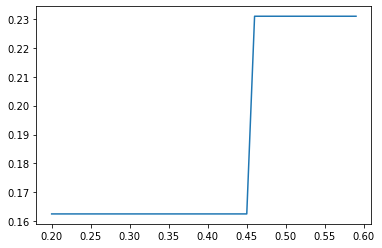

In [ ]:
sns.lineplot(th_value, score_list)

In [ ]:
# threshold terbaik
print('best threshold', best_th)
print('best score', best_score)

best threshold 0.46
best score 0.23098591549295772


\* Berarti hasil prediksinya akan sama saja dengan threshold=0.5 karena f1-score pada threshold=0.46 sama dengan f1-score pada threshold=0.50

In [ ]:
# train model pada train set
model.fit(X_train, y_train)

# sekarang predict model pada test set dengan threshold terbaik
y_prob = model.predict_proba(X_test)[:,1]
y_pred = np.where(y_prob>best_th,1,0)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84       972
           1       0.13      0.82      0.23        50

    accuracy                           0.73      1022
   macro avg       0.56      0.77      0.53      1022
weighted avg       0.95      0.73      0.81      1022



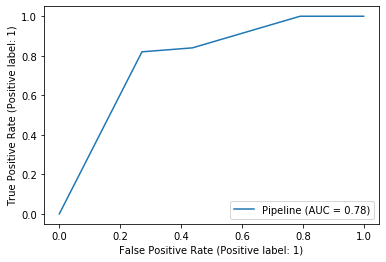

In [ ]:
plot_roc_curve(model, X_test, y_test)

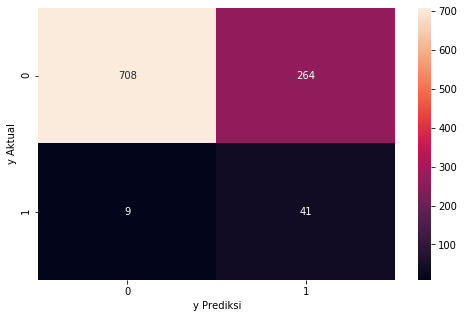

In [ ]:
# after tuning

f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('y Prediksi')
plt.ylabel('y Aktual');

Hasilnya sama saja dengan menggunakan threshold 0.5

## **Random Forest**

- Explore: Bagaimana setiap feature berhubungan dengan apakah seseorang survive/alive? Lakukan EDA dan jelaskan hasil yang didapat!

- Splitting: 80-20, stratify: y, random_state = 0

- Preprocessing:
    - Drop deck
    - Isi missing value menggunakan simple imputer
    - One hot encoding: sex, alone
    - Ordinal encoding: class
    - Binary encoding: embark town

- Model selection:
    - Evaluation metrics dengan F1_score
    - Kandidat model: Logreg, KNN, DecisionTreeClassifier, RandomForestClassifier
    - Pilih 2 model terbaik dan lakukan Hyperparameter tuning pada kedua model tersebut
    - Buat kesimpulan model mana yang terbaik untuk titanic dataset

\* tips: gunakan pipeline ketika diperlukan untuk menghindari data leakage.

\* Hyperparameter tuning untuk Random Forest:
- n_estimators = 100-2000
- max_features = 2-8
- max_depth = 5-100
- min_samples_split = 2-20
- min_samples_leaf = 1-20